# Comparison of different prediction models on the Titanic dataset

The goal of this tutorial is to compare performance of different models on the famous Titanic dataset to predict passengers who survived the shipwreck. Before model construction, I go through basic statistics, cleaning and vizualization.<br>

Now let's start with importing some packages.

In [216]:
# Import Data wrangling packages
import pandas as pd
import numpy as np
# Import Data Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
# import prediction packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, auc
# Remove warnings
import warnings
warnings.filterwarnings("ignore")

### Reading the data

The first step is to download the training and testing datasets from [Kaggle](https://www.kaggle.com/c/titanic/data) and preview the first rows with the `head()` function.

In [217]:
df_train = pd.read_csv('titanic/train.csv')
df_test = pd.read_csv('titanic/test.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Exploring the Data

Just Playing with different commands to get more familiar with the data.<br>

Getting the feature names:

In [218]:
df_train.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

<br> Previewing the last 5 samples

In [219]:
df_train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


Checking the data types and missing values in the data. It is important to make sure that the features have the correct types. Otherwise, we can set the expected types when reading the csv file or change them afterwards. Also, it is important to be aware of the missing values. For instance, `Cabin` here has many missing values which needs to be discarded or imputed to avoid bias in the rest of the analysis.

In [220]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


<br> `describe()` can be used to check the distribution properties of numerical or categorical feature values

In [221]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<br> For each categorical variable we can get total counts, number of unique values and the most frequent category with its frequency, by passing `include=['O']` argument to `describe()`

In [222]:
df_train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Danoff, Mr. Yoto",male,347082,B96 B98,S
freq,1,577,7,4,644


<br> Let's check the balance of target feature in the training data, i.e how many people survived:

In [223]:
df_train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

<br> Is there a gender bias among the people who survived?

In [224]:
df_train[['Survived','Sex']].groupby('Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


<br> Compare the mean age of passengers who survived and not survived

In [225]:
df_train[['Survived','Age']].groupby('Survived').mean()

,Age
Survived,
0,30.626179
1,28.343690


### Vizualizing Data

We saw that the mean age of the survived passerngers does not differ very much from not-survived. Now let's look deeper into that by visualizing age distribution for each group.

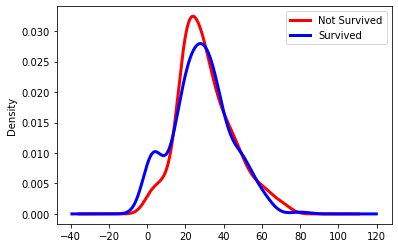

In [226]:
df_train.Age[(df_train.Survived == 0)].plot(kind="kde", linewidth = 3, color='red', label = 'Not Survived')
df_train.Age[df_train.Survived == 1].plot(kind="kde", linewidth = 3, color='blue', label = 'Survived')
plt.legend()

This plot indicates some differences between the target groups and suggests using the age feature for our model.<br>

Now let's plot the sex differences

<AxesSubplot:xlabel='Sex'>

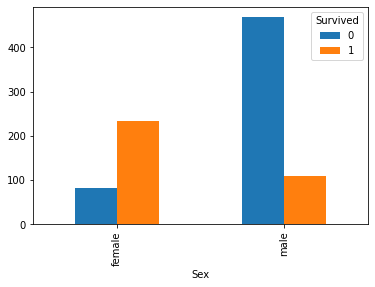

In [227]:
pd.crosstab(df_train.Sex,df_train.Survived).plot(kind='bar')

It seems women had better survival rate than men suggesting that the sex feature should also be considered for our models.<br>

How about the ticket class?

<AxesSubplot:xlabel='Pclass'>

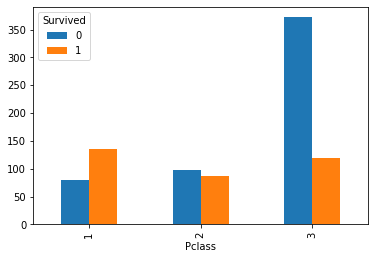

In [228]:
pd.crosstab(df_train.Pclass,df_train.Survived).plot(kind='bar')

This plot shows that ticket class 3 had the largest number of passengers, and most of them did not survive. This feature also should be consider in training model.<br>

Checking the port of embarkation `C = Cherbourg, Q = Queenstown, S = Southampton` with survival

<AxesSubplot:xlabel='Embarked'>

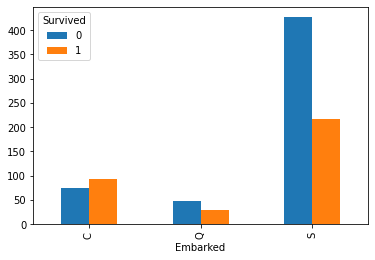

In [229]:
pd.crosstab(df_train.Embarked,df_train.Survived).plot(kind='bar')

The plot suggests that Embarked should be considered in training model. <br>

We can also see that the number of siblings / spouses aboard the Titanic made some differences in the survival

<AxesSubplot:xlabel='SibSp'>

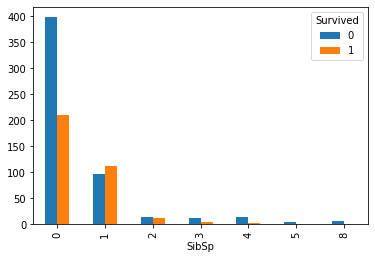

In [230]:
pd.crosstab(df_train.SibSp,df_train.Survived).plot(kind='bar')

We can also visualize the survival based on more that one feature.

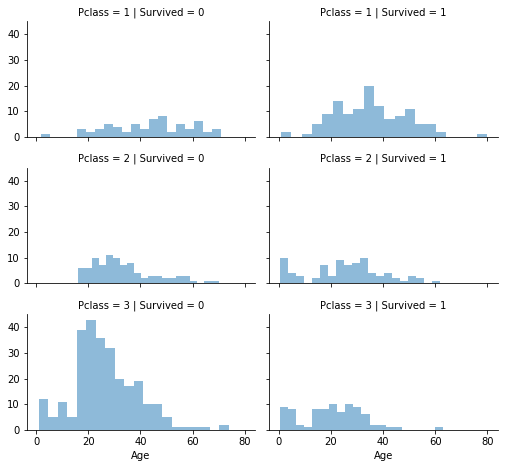

In [231]:
# Pclass & Age
grid = sns.FacetGrid(df_train, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

We can see that most passengers in Pclass 3 who were around age 20 did not survive. Also most of the infants in Pclass 2 survived.<br>

let's check the survival based on sex and Embarked:

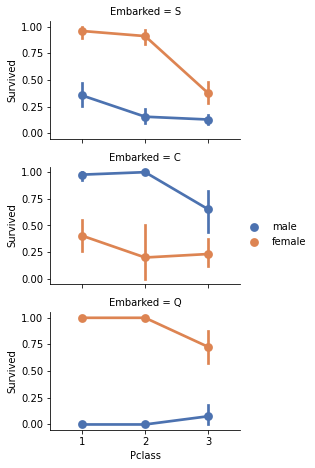

In [232]:
grid = sns.FacetGrid(df_train, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

<br>Here we can see that female had higher chance of survival except in Embarked C. <br>

We also can check the corelation between categorical features and numerical features. Here we check correlation between Embarked, Fare, Sex with survival. <br>
    

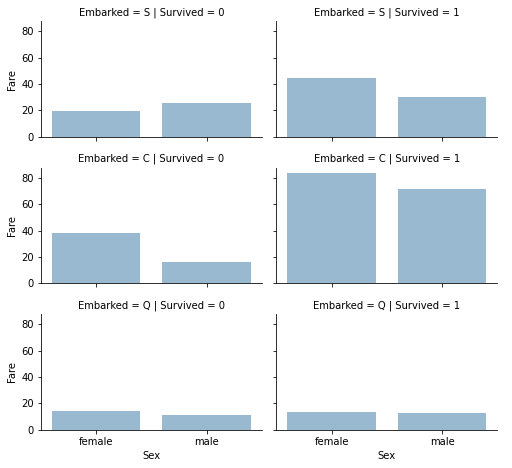

In [233]:
grid = sns.FacetGrid(df_train, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

We can see that passengers who paid higher had more chance to survive. Aslo, as confirmed before, female survived more than male. <br>

### Preparing the Data

We start with droping the features that assume that is not important for both training and testing datasets.

In [234]:
df_train = df_train.drop(['Name', 'Ticket','Cabin'], axis=1)
df_test = df_test.drop(['Name', 'Ticket','Cabin'], axis=1)
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


<br> Here we set the index of the table to passengerId <br>

In [235]:
df_train = df_train.set_index('PassengerId')
df_test = df_test.set_index('PassengerId')

<br>Let's Convert Catogarical features to dummies, which means convert features which contain strings to numerical values

In [236]:
df_train = df_train.replace (['female','male'],[0, 1])
df_train['Embarked'] = pd.get_dummies(df_train['Embarked'])
df_test = df_test.replace (['female','male'],[0, 1])
df_test['Embarked'] = pd.get_dummies(df_test['Embarked'])
df_train.head()
df_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
892,3,1,34.5,0,0,7.8292,0
893,3,0,47.0,1,0,7.0000,0
894,2,1,62.0,0,0,9.6875,0
895,3,1,27.0,0,0,8.6625,0
896,3,0,22.0,1,1,12.2875,0


<br> `isna()` function can be used to check the features that still have missing values

In [237]:
df_train.isna().sum(axis=0)

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      0
dtype: int64

<br> Remove Nan in Embarked and replace Nan in age column with average

In [238]:
df_train['Age'].fillna(df_train['Age'].mean(), inplace=True)
df_test['Age'].fillna(df_test['Age'].mean(), inplace=True)
df_train['Fare'].fillna(df_train['Fare'].dropna().median(), inplace=True)
df_test['Fare'].fillna(df_test['Fare'].dropna().median(), inplace=True)
df_train.dropna(subset=['Embarked'],inplace=True)
df_test.dropna(subset=['Embarked'],inplace=True)

<br> We can group age into 5 groups:

In [239]:
 age_labels = [0, 1, 2, 3, 4]
df_train['age_group'] = pd.qcut(df_train['Age'], q=5, labels=age_labels)
df_test['age_group'] = pd.qcut(df_test['Age'], q=5, labels=age_labels)
df_train.drop(['Age'], axis=1, inplace=True)
df_test.drop(['Age'], axis=1, inplace=True)

    
df_train.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,age_group
PassengerId,,,,,,,,
1,0,3,1,1,0,7.2500,0,1
2,1,1,0,1,0,71.2833,1,3
3,1,3,0,0,0,7.9250,0,1
4,1,1,0,1,0,53.1000,0,3
5,0,3,1,0,0,8.0500,0,3


<br> In order to prepare the testing data, we need to remove the target feature.

In [240]:
xtrain = df_train.drop(['Survived'], axis=1)
ytrain = df_train['Survived']
ytrain.head()

PassengerId
1    0
2    1
3    1
4    1
5    0
Name: Survived, dtype: int64

<br> Also we can check the percentage of the survival rate:

In [241]:
not_survived = len(df_train[df_train['Survived']==0])
survived = len(df_train[df_train['Survived']==1])
print(survived)
print(not_survived)
percSurvived = survived / (survived + not_survived)
print('percentage of survival', percSurvived * 100)

342
549
percentage of survival 38.38383838383838


## Model

After cleaning the data, I start building supervised classification models.

#### Logistic Regression

Let's split the dataset to train and test. Note that the .csv file that availble in Kaggle does not have any label, so we need to use the training dataset for the validation.

In [273]:
x_train, x_test, y_train, y_test = train_test_split(xtrain, ytrain, test_size=0.2, random_state=10)

<br> fitting the model using `sklearn`.

In [274]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
ypred = logreg.predict(x_test)

<br>Calculate accuracy, precision and recall

In [297]:
acc_log = round(accuracy_score(y_test, ypred),3)
prec_log = round(precision_score(y_test, ypred),2)
recall_log = round(recall_score(y_test, ypred),2)

print('accuracy:', acc_log)
print('precision:', prec_log)
print('recall:', recall_log)

accuracy: 0.821
precision: 0.73
recall: 0.76


 <br>Predict the test dataset provided by Kaggle using logistic regression model which can be submmitted to the competition.  

In [276]:
titanpred = logreg.predict(df_test)
PassengerId= df_test.index
data = {'PassengerId':PassengerId, 'Survived': titanpred}
titanprediction = pd.DataFrame(data).to_csv('titanprediction.csv',index=False)


#### Support Vector Machine


Support Vector Classification (SVC)

For other models, same as logistic regression, I fit the model and calculated the precision, accuracy and recall.

In [277]:
svc = SVC()
svc.fit(x_train, y_train)
ypred = svc.predict(x_test)

acc_SVM = round(accuracy_score(y_test, ypred),2)
prec_SVM = round(precision_score(y_test, ypred),2)
recall_SVM = round(recall_score(y_test, ypred),2)

print('accuracy:', acc_SVM)
print('precision:', prec_SVM)
print('recal:', recall_SVM)

accuracy: 0.73
precision: 0.79
recal: 0.31


#### K-Nearest Neighbor Classifier

In [278]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train, y_train)
ypred = knn.predict(x_test)
print(knn.score(x_train,y_train))

acc_KNN = round(accuracy_score(y_test, ypred),2)
prec_KNN = round(precision_score(y_test, ypred),2)
recall_KNN = round(recall_score(y_test, ypred),2)

print('accuracy:', acc_KNN)
print('precision:', prec_KNN)
print('recal:', recall_KNN)


0.8553370786516854
accuracy: 0.71
precision: 0.58
recal: 0.61


#### Gaussian Naive Bayes

In [279]:
gaussian = GaussianNB()
gaussian.fit(x_train, y_train)
ypred = gaussian.predict(x_test)

print(gaussian.score(x_train,y_train))

acc_NB = round(accuracy_score(y_test, ypred),2)
prec_NB = round(precision_score(y_test, ypred),2)
recall_NB = round(recall_score(y_test, ypred),2)

print('accuracy:', acc_NB)
print('precision:', prec_NB)
print('recal:', recall_NB)

0.7907303370786517
accuracy: 0.79
precision: 0.69
recal: 0.73


<br>Predict the test dataset provided by Kaggle using Naive Bayes model, which can be submmitted to the competition.

In [280]:
titanpred = gaussian.predict(df_test)
PassengerId= df_test.index
data = {'PassengerId':PassengerId, 'Survived': titanpred}
titanpredictionNB = pd.DataFrame(data).to_csv('titanpredictionNB.csv',index=False)

#### Stochastic Gradient Descent

In [281]:
sgd = SGDClassifier()
sgd.fit(x_train, y_train)
ypred = sgd.predict(x_test)

acc_SGD = round(accuracy_score(y_test, ypred),2)
prec_SGD = round(precision_score(y_test, ypred),2)
recall_SGD = round(recall_score(y_test, ypred),2)

print('accuracy:', acc_SGD)
print('precision:', prec_SGD)
print('recal:', recall_SGD)

print(sgd.score(x_train, y_train))

accuracy: 0.79
precision: 0.73
recal: 0.65
0.7794943820224719


#### Decision Tree

In [282]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(x_train, y_train)
ypred = decision_tree.predict(x_test)

acc_decision_tree = round(accuracy_score(y_test, ypred),2)
prec_decision_tree  = round(precision_score(y_test, ypred),2)
recall_decision_tree = round(recall_score(y_test, ypred),2)

print('accuracy:', acc_decision_tree )
print('precision:', prec_decision_tree )
print('recal:', recall_decision_tree )

accuracy: 0.81
precision: 0.71
recal: 0.77


#### Random Forest

In [296]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(x_train, y_train)
ypred = random_forest.predict(x_test)

acc_random_forest = round(accuracy_score(y_test, ypred),4)
prec_random_forest = round (precision_score(y_test, ypred),2)
recall_random_forest = round(recall_score(y_test, ypred),2)

print('accuracy:', acc_random_forest)
print('precision:', prec_random_forest)
print('recal:', recall_random_forest)

accuracy: 0.8212
precision: 0.73
recal: 0.76


In order to make the comparison easier, I saved all the models' accuracy in a table and sort them.

In [298]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
              'Stochastic Gradient Decent', 
              'Decision Tree'],
    'Score': [acc_SVM, acc_KNN, acc_log, 
              acc_random_forest, acc_NB, acc_SGD, 
               acc_decision_tree]})
models.sort_values(by='Score', ascending=False)


,Model,Score
3,Random Forest,0.8212
2,Logistic Regression,0.8210
6,Decision Tree,0.8100
4,Naive Bayes,0.7900
5,Stochastic Gradient Decent,0.7900
0,Support Vector Machines,0.7300
1,KNN,0.7100


The Random Forest model has higher accuracy.<br>

### ROC Curve

Let's compare the models using ROC curve. In order to have ROC curve of all models in one figure, I again train the models on training set and then predict the probabilies on the testing set. After predicting the probabilities, we’ll calculate the False positive rates, True positive rate, and AUC scores.

<br> I define a dataframe for the results. Then, Instantiate the classfiers and make a list

In [285]:
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])
classifiers = [LogisticRegression(random_state=1234), 
               GaussianNB(), 
               KNeighborsClassifier(), 
               DecisionTreeClassifier(random_state=1234),
               RandomForestClassifier(random_state=1234)]


<br> Let's train the models and record the results

In [286]:
for cls in classifiers:
    model = cls.fit(x_train, y_train)
    yproba = model.predict_proba(x_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

result_table.set_index('classifiers', inplace=True)

<br> Plot the ROC curve

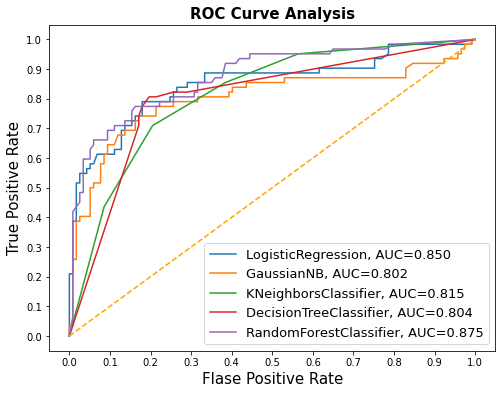

In [287]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

 Random Forest has higher AUC.The performnes of all models are relatively close. <br>

You can save your ROC curve using `savefig` function

In [288]:
fig.savefig('multiple_roc_curve.png')